<h1 align="center">Facial Recognition</h1>

In [77]:
import numpy as np
from os import walk
from scipy.misc import imread
import random
import scipy.linalg as la

from matplotlib import pyplot as plt, rcParams
%matplotlib inline

### Helper Functions

In [78]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, flatten=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, flatten=True))

Display a face from the dataset of faces we're using.

In [79]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    img = np.reshape(image,(m,n))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

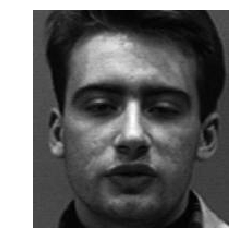

In [80]:
# Show a face from the faces94 dataset.
for i in sample_faces(1):
    show(i)

## Facial Recognition Class

In [81]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F (mn matrix): array of mn column vectors that are faces (images)
        mean_face (matrix): column vector that is the mean of all faces stored in F
        F_bar (mn matrix): array of mn column vectors shifted by mean_face
        U (matrix): U from the SVD of F_bar
    """
    def __init__(self, path='./faces94'):
        """Initialize all attributes.
        This is the main part of the computation.
        """
        F = get_faces(path)
        mean_face = np.mean(F, axis=1)
        F_bar = np.subtract(F.T, mean_face).T
        U,S,V = la.svd(F_bar, full_matrices=False)
        
        self.mean_face = mean_face
        self.F_bar = F_bar
        self.F = F
        self.U = U
        
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        
        return (self.U[:,:s]).T@A

    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        
        g_bar = g - self.mean_face
        g_hat = self.project(g_bar,s)
        F_hat = self.project(self.F_bar, s)        
        x= np.subtract(F_hat.T,g_hat)
        j = np.argmin(la.norm(x,axis=1, ord=2))
        return j

    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        j = self.find_nearest(image, s)
        return self.F[:,j]
        

Initialize a `FacialRec` object and display its mean face, plus an original image and its shifted face.

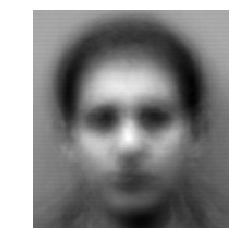

In [82]:
# Display the mean face.
A = FacialRec()
plt.axis("off")
show(A.mean_face)

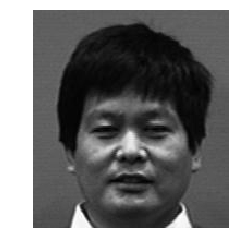

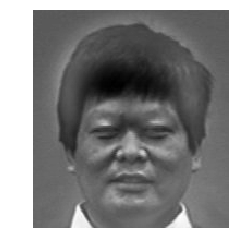

In [83]:
# Display an image along with its mean-shifted face.
i = random.randint(1,153)
plt.axis("off")
show(A.F[:,i])
show(A.F_bar[:,i])

Display some of the eigenfaces (the columns of $U$).


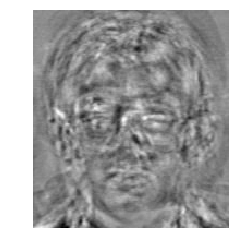

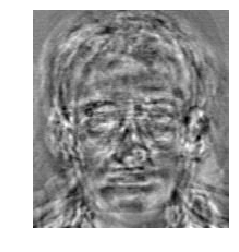

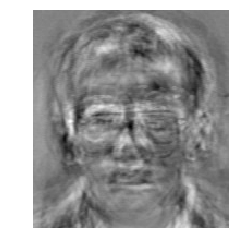

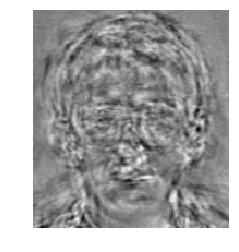

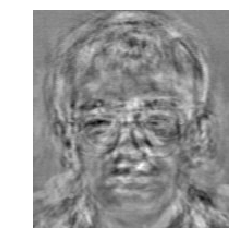

In [84]:
# Display some of the eigenfaces.
plt.axis("off")
for _ in range(5):
    i = random.randint(1,153)
    show(A.U[:,i])

Compute the corresponding $s$-projection $\widehat{\mathbf{f}}_i$ for several values of $s$, then compute the reconstruction $\widetilde{\mathbf{f}}_i$ for a specific image, then display each of the reconstructions and the original image.

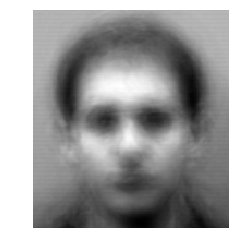

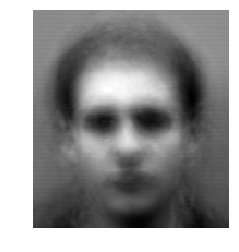

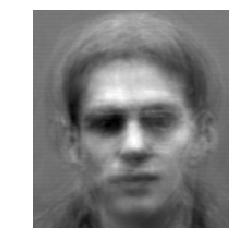

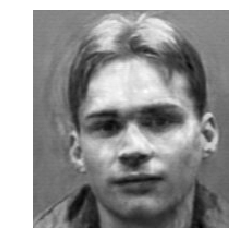

In [85]:
# Display a face image reconstructed with various numbers of eigenfaces. 
i = random.randint(1,153)
plt.axis("off")
f_hat = A.F_bar[:,i]
for s in [1,5,19,75]:
    f_tilda = A.project(f_hat,s)
    show((A.U[:,:s]@f_tilda)+A.mean_face)

Recognize test faces - show the original test image, and the face from the database that most closely resembles it.

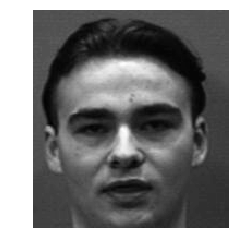

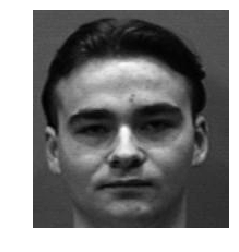

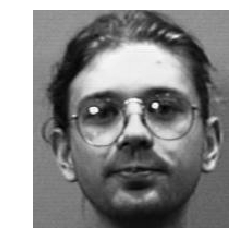

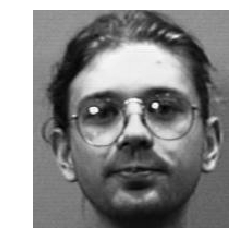

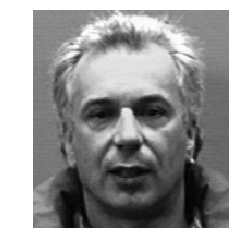

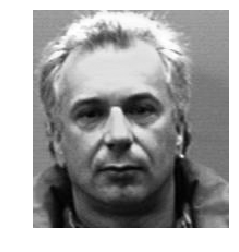

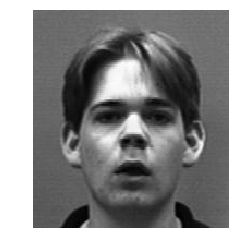

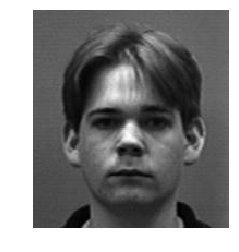

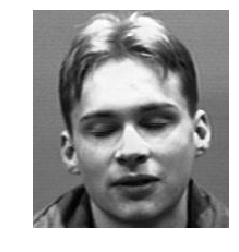

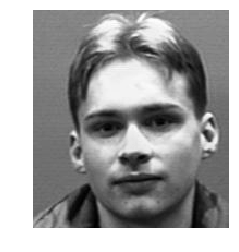

In [87]:
# Display some random images along with their closest match.
for face in sample_faces(5):
    close = A.match(face)
    show(face)
    show(close)